# Example - Live-Cell Actin Filaments

This notebook is a demonstration of the super-resolution fluorescence imaging method, pysofi, on live-cell imaging data. **(TODO: add sample data details, e.g. what cell. fluorescent protein, magnification, EMCCD camera)**. The dataset is composed of 20 tiff videos in sequence ('Block1.tif' to 'Block20.tif'), and each video has 200 frames. This notebook shows a standard workflow of pysofi to achieve high order Super-resolution Optical Fluctuation Imaging (SOFI) images. Briefly, we demonstrate a pipeline of
1. Fourier interpolation 
2. Moments reconstrtuction or cumulants reconstruction 
3. Noise filtering 1 
4. Shrinking kernel deconvolution
5. Noise filtering 2 
6. Local dynamic range compression (ldrc)

In the end, the processed image / video will be saved into a new tiff file with the colormap the user selects.

Before running the notebook, please make sure you have set up the environment. You can install all required packages with:

<pre><code>pip install -r environment.txt
</code></pre>

In [19]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import visualization as v
from functions import (data, filtering, masks, finterp)
import tifffile as tiff
%matplotlib inline
import matplotlib.pyplot

## Load Image / Video (Tiff Files)

This sample dataset has 20 tiff files in an order from 1 to 20. First, we generate a list of filenames by their sequence, and load all videos into a dictionary (dset), where keys are filenames in the list (e.g. 'Block1.tif') and values are Data objects (<functions.data.Data at 0x1cab5599760>).

In [21]:
filenum = 20
filepath = '../SampleData'
filenames = ['Block' + str(i+1) + '.tif' for i in range(filenum)]
dset = {}

for filename in filenames:
    dset[filename] = data.Data(filepath, filename)

If you don't get any message, the file is loaded successfully. We can check basic information of each data object including **dimensions** and **frame numbers**. For instance, for the third video ('Block3.tif'), we can get:

In [22]:
print("Information of '" + filenames[2] + "':\n")
    
print('Number of frames: ', dset[filenames[2]].n_frames)
print('Pixel numbers: ', dset[filenames[2]].xdim, '*', dset[filenames[2]].ydim)

Information of 'Block3.tif':

Number of frames:  200
Pixel numbers:  450 * 450


We can also load one frame into an array with function [<code>get_frame(frame_num)<code>](https://github.com/xiyuyi/pysofi/blob/master/functions/data.py).

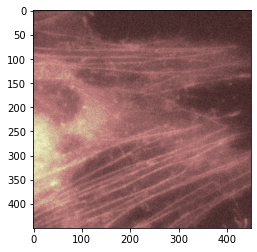

In [23]:
frame_im = dset[filenames[2]].get_frame(2)
plt.imshow(frame_im, cmap='pink')

## 1. Fourier Interpolation

This step performs Fourier interpolation to generate new pixels between physical pixels and reduce pixel sizes of each frame [ref1 - fSOFI, ref2 - fInterpForTiff](https://github.com/xiyuyi/xy_fInterp_forTIFF). The resulting TIFF file can be applied for SOFI processing to produce fSOFI results. 

We can pass a single frame and a list of interpolation factors to [<code>finterp.fourier_interp_array</code>](https://github.com/xiyuyi/pysofi/blob/master/functions/finterp.py), or carry out fourier interpolation on the video (data object) directly with <code>data.finterp_tiffstack</code>. Note that this step might consume large memory or time depending on the tiff file (dimensions, frame number) and the number of new pixels generated. 

We can pass a few parameters to <code>finterp_tiffstack</code>:
+ <code>interp_num_lst</code>: a list of interpolation factors (integers). Interpolation factor represents the number of pixels in the pysical resolution. Based on Nyquist sampling theorem, we recommend to set the interpolation factor to be two times the highest order for moments reconstruction. For instance, if we will generate fourth-order moment-reconstructed image, we set <code>interp_num_lst = [8]</code>, and the new pixel size $d_{new} = \frac{d_{ori}}{8}$.
+ <code>mvlength</code>: the length of the video for interpolation. To save time, for this demo, we choose a small section of our tiff file and set <code>mvlength = 20 </code>.
+ <code>save_option</code>: whether to save the interpolated images into tiff files. Seperate tiff files will be produced for individual interpolation factors in <code>interp_num_lst</code>.
+ <code>return_option</code>: whether to return the interpolated image series as 3d arrays. This is helpful for checking interpolated images and plotting them directly. We recommend to save the interpolated image stack as tiff files instead of returning them if dimensions and number of frames are large.

The user can carry out interpolation first and save the interpolated image / video for following pysofi steps, or skip this step and set <code>finterp = True </code> in moments or cumulants reconstructions. We recommend to set the interpolation factor two times the reconstruction order number.

In [24]:
# Fourier interpolation on 'Block10'. You can skip this step if you do not need to save interpolated images.
dest[filenames[9]].finterp_tiffstack(interp_num_lst = [8], mvlength = 20, save_option = True, return_option = False)

NameError: name 'dest' is not defined

In [ ]:
5.0000 !=5

## 2. Moments and cumulants reconstruction

Intro Calculate M6 on each video [0:9] - for Demo. Here, we choose order number = 6

**TODO: add finterp**

Due to cusp-artefects (ref), here we choose a practical method using moments reconstruction. For even orders, we can alaways get positive values for each pixel, avioding cusp-artefects for reconstructed images.

In [ ]:
m_set = {}
for filename in filenames:
    m_set[filename] = dset[filename].moments_images(6)[6]

Plot M6 of block 6

In [ ]:
# Plot M6 of block 6
v.bokeh_visualization(m_set[filenames[5]])

In [ ]:
# 3. Noise filtering on M6 seriers
nf = masks.gauss1D_mask(shape = (1,21), sigma = 2)
filtering.noise_filter1d(dset, m_set, nf, filtername = 'noise filter after M6')
dset[filenames[1]].filtered     # filtered M6 of block 2

In [ ]:
# 4. Shrinking kernal deconvolution on filtered M6
deconv_psf0 = masks.gauss2D_mask((51, 51), 2)
deconv_psf0 = deconv_psf0 / np.max(deconv_psf0)
deconv_lambda = 1.5
deconv_iter = 20
deconv_set  ={}

for filename in filenames:
    # print(filename)
    im = dset[filename].filtered
    deconv_set[filename] = dset[filename].deconvsk(deconv_psf0, im, deconv_lambda, deconv_iter)
    # tiff.imwrite('deconv.tif', deconv_im, append=True)    # save tiff stack

In [ ]:
# 5. Noise filtering on deconvoluted image sereis
nf = masks.gauss1D_mask(shape = (1,21), sigma = 2)
filtering.noise_filter(dset, deconv_set, nf, filtername = 'noise filter after deconvolution', filenames=filenames)
v.bokeh_visualization(dset[filenames[3]].filtered)     # filtered deconvoluted image of block 4

In [ ]:
# 6. LDRC on the filtered image sereis
window_size = 25
ldrc_set = {}

for filename in filenames:
    mask_im = dset[filename].average_image()
    ldrc_set[filename] = dset[filename].ldrc(window_size = window_size, mask_im = mask_im, input_im = dset[filename].filtered)


In [ ]:
# Plot final image of block 4
v.bokeh_visualization(ldrc_set[filenames[5]])

In [ ]:
# save the final image stack as a .tif file
import tifffile as tiff
for filename in filenames:
    tiff.imwrite('demo_pysofi.tif', ldrc_set[filename], append=True)

In [ ]:
# save the final image stack as a .tif file with rounding to int16 and increased contrast to view in imageJ
for filename in filenames:
    tiff.imwrite('demo_pysofi_int16.tif', np.int16(np.around(ldrc_set[filename]*2)), append=True)